# Entrenamiento de Modelos - California Housing Dataset


**Objetivo**: Entrenar, comparar y seleccionar el mejor modelo para predicción de precios de viviendas.

**Modelos a entrenar**:
- Random Forest Regressor
- XGBoost Regressor
- LightGBM Regressor

## 1. Importar Librerías

In [10]:
import pandas as pd
import numpy as np
import json
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Feature Engineering
from ft_engineering import prepare_data_for_training

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model Persistence
import joblib
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Librerías importadas exitosamente")
print(f"Versión de pandas: {pd.__version__}")
print(f"Versión de numpy: {np.__version__}")

✓ Librerías importadas exitosamente
Versión de pandas: 2.3.3
Versión de numpy: 2.3.4


## 2. Cargar Configuración

In [11]:
# Cargar configuración desde config.json
with open('../config.json', 'r') as f:
    config = json.load(f)

print("=" * 80)
print("CONFIGURACIÓN DEL PROYECTO")
print("=" * 80)
for key, value in config.items():
    print(f"{key:20s}: {value}")
print("=" * 80)

# Configuración adicional
RANDOM_STATE = config.get('random_state', 42)
MODEL_OUTPUT_DIR = f"../{config.get('model_output_dir', 'models/')}"
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

CONFIGURACIÓN DEL PROYECTO
project_code        : mlops-pipeline
project_name        : MLOps Pipeline - California Housing
data_file           : Base_de_datos.csv
model_output_dir    : models/
random_state        : 42


## 3. Preparar Datos con Feature Engineering

In [12]:
# Ejecutar pipeline de feature engineering completo
X_train, X_test, y_train, y_test, preprocessor, feature_names = prepare_data_for_training(
    config_path='../config.json',
    test_size=0.2,
    save_preprocessor=True
)

FEATURE ENGINEERING PIPELINE - CALIFORNIA HOUSING

[1/6] Cargando datos...
✓ Dataset cargado: 20,640 filas × 10 columnas

[2/6] Creando features derivados...
✓ Features derivados creados:
  • rooms_per_household
  • bedrooms_per_room
  • population_per_household

[3/6] Preparando features y target...

✓ Features preparados:
  • Features numéricos: 11
  • Features categóricos: 1
  • Variable objetivo: median_house_value

[4/6] Dividiendo datos (test_size=0.2)...
  • Train: 16,512 muestras
  • Test: 4,128 muestras

[5/6] Aplicando transformaciones...

✓ Pipeline de preprocesamiento construido:
  • Numéricos: Imputación (mediana) + StandardScaler
  • Categóricos: Imputación (constante) + OneHotEncoder
✓ Total de features después de transformación: 16

✓ Datos de entrenamiento transformados: (16512, 16)
✓ Datos de prueba transformados: (4128, 16)

[6/6] Guardando preprocessor...

✓ Preprocessor guardado en: ../models/preprocessor_20251110_025254.pkl
✓ Nombres de features guardados en: ../m

In [13]:
# Verificar dimensiones de los datos preparados
print("\n" + "=" * 80)
print("DATOS PREPARADOS PARA ENTRENAMIENTO")
print("=" * 80)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Total features: {len(feature_names)}")
print("\nPrimeros 10 features:")
for i, name in enumerate(feature_names[:10], 1):
    print(f"  {i:2d}. {name}")
if len(feature_names) > 10:
    print(f"  ... y {len(feature_names) - 10} más")
print("=" * 80)


DATOS PREPARADOS PARA ENTRENAMIENTO
X_train shape: (16512, 16)
X_test shape: (4128, 16)
y_train shape: (16512,)
y_test shape: (4128,)
Total features: 16

Primeros 10 features:
   1. longitude
   2. latitude
   3. housing_median_age
   4. total_rooms
   5. total_bedrooms
   6. population
   7. households
   8. median_income
   9. rooms_per_household
  10. bedrooms_per_room
  ... y 6 más


## 4. Definir Modelos a Entrenar

In [14]:
# Diccionario de modelos a entrenar
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )
}

print("=" * 80)
print("MODELOS CONFIGURADOS")
print("=" * 80)
for name, model in models.items():
    print(f"\n{name}:")
    print(f"  {model.__class__.__name__}")
print("\n" + "=" * 80)

MODELOS CONFIGURADOS

Random Forest:
  RandomForestRegressor

XGBoost:
  XGBRegressor

LightGBM:
  LGBMRegressor



## 5. Función de Evaluación de Modelos

In [15]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evalúa un modelo con múltiples métricas de regresión.
    
    Args:
        y_true: Valores reales
        y_pred: Valores predichos
        model_name: Nombre del modelo
        
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Calcular MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE (%)': mape
    }
    
    return metrics

print("✓ Función de evaluación definida")

✓ Función de evaluación definida


## 6. Entrenar y Evaluar Modelos

In [16]:
# Diccionario para almacenar resultados
results = {
    'train_metrics': [],
    'test_metrics': [],
    'trained_models': {},
    'predictions': {},
    'training_times': {}
}

print("=" * 80)
print("ENTRENANDO MODELOS")
print("=" * 80)

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Entrenando: {model_name}")
    print(f"{'='*80}")
    
    # Medir tiempo de entrenamiento
    start_time = time.time()
    
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Calcular tiempo
    training_time = time.time() - start_time
    results['training_times'][model_name] = training_time
    
    print(f"✓ Entrenamiento completado en {training_time:.2f} segundos")
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Guardar predicciones
    results['predictions'][model_name] = {
        'train': y_train_pred,
        'test': y_test_pred
    }
    
    # Evaluar en conjunto de entrenamiento
    train_metrics = evaluate_model(y_train, y_train_pred, model_name)
    results['train_metrics'].append(train_metrics)
    
    # Evaluar en conjunto de prueba
    test_metrics = evaluate_model(y_test, y_test_pred, model_name)
    results['test_metrics'].append(test_metrics)
    
    # Guardar modelo entrenado
    results['trained_models'][model_name] = model
    
    # Imprimir resultados
    print(f"\nMétricas en TRAIN:")
    print(f"  MAE:  ${train_metrics['MAE']:,.2f}")
    print(f"  RMSE: ${train_metrics['RMSE']:,.2f}")
    print(f"  R²:   {train_metrics['R2']:.4f}")
    
    print(f"\nMétricas en TEST:")
    print(f"  MAE:  ${test_metrics['MAE']:,.2f}")
    print(f"  RMSE: ${test_metrics['RMSE']:,.2f}")
    print(f"  R²:   {test_metrics['R2']:.4f}")

print(f"\n{'='*80}")
print("✅ TODOS LOS MODELOS ENTRENADOS")
print(f"{'='*80}")

ENTRENANDO MODELOS

Entrenando: Random Forest
✓ Entrenamiento completado en 2.28 segundos

Métricas en TRAIN:
  MAE:  $15,365.62
  RMSE: $24,649.66
  R²:   0.9545

Métricas en TEST:
  MAE:  $31,881.35
  RMSE: $49,661.48
  R²:   0.8118

Entrenando: XGBoost
✓ Entrenamiento completado en 2.28 segundos

Métricas en TRAIN:
  MAE:  $15,365.62
  RMSE: $24,649.66
  R²:   0.9545

Métricas en TEST:
  MAE:  $31,881.35
  RMSE: $49,661.48
  R²:   0.8118

Entrenando: XGBoost
✓ Entrenamiento completado en 0.41 segundos

Métricas en TRAIN:
  MAE:  $22,378.13
  RMSE: $32,191.79
  R²:   0.9225

Métricas en TEST:
  MAE:  $30,041.08
  RMSE: $45,710.14
  R²:   0.8406

Entrenando: LightGBM
✓ Entrenamiento completado en 0.41 segundos

Métricas en TRAIN:
  MAE:  $22,378.13
  RMSE: $32,191.79
  R²:   0.9225

Métricas en TEST:
  MAE:  $30,041.08
  RMSE: $45,710.14
  R²:   0.8406

Entrenando: LightGBM
✓ Entrenamiento completado en 0.26 segundos

Métricas en TRAIN:
  MAE:  $27,218.29
  RMSE: $39,930.74
  R²:   0.

## 7. Comparación de Resultados

In [17]:
# Crear DataFrames con los resultados
train_results_df = pd.DataFrame(results['train_metrics'])
test_results_df = pd.DataFrame(results['test_metrics'])

# Agregar tiempos de entrenamiento
train_results_df['Training Time (s)'] = train_results_df['Model'].map(results['training_times'])

print("=" * 80)
print("RESULTADOS EN CONJUNTO DE ENTRENAMIENTO")
print("=" * 80)
print(train_results_df.to_string(index=False))

print("\n" + "=" * 80)
print("RESULTADOS EN CONJUNTO DE PRUEBA")
print("=" * 80)
print(test_results_df.to_string(index=False))

RESULTADOS EN CONJUNTO DE ENTRENAMIENTO
        Model          MAE          MSE         RMSE       R2  MAPE (%)  Training Time (s)
Random Forest 15365.623897 6.076055e+08 24649.655679 0.954547  8.425678           2.284690
      XGBoost 22378.130859 1.036311e+09 32191.786282 0.922477 12.506500           0.405178
     LightGBM 27218.290904 1.594464e+09 39930.735389 0.880723 15.187636           0.256436

RESULTADOS EN CONJUNTO DE PRUEBA
        Model          MAE          MSE         RMSE       R2  MAPE (%)
Random Forest 31881.349726 2.466263e+09 49661.483296 0.811794 17.800124
      XGBoost 30041.080078 2.089417e+09 45710.139269 0.840552 16.903571
     LightGBM 30554.053653 2.104733e+09 45877.374593 0.839383 17.197482


### 7.1 Visualización de Comparación de Métricas

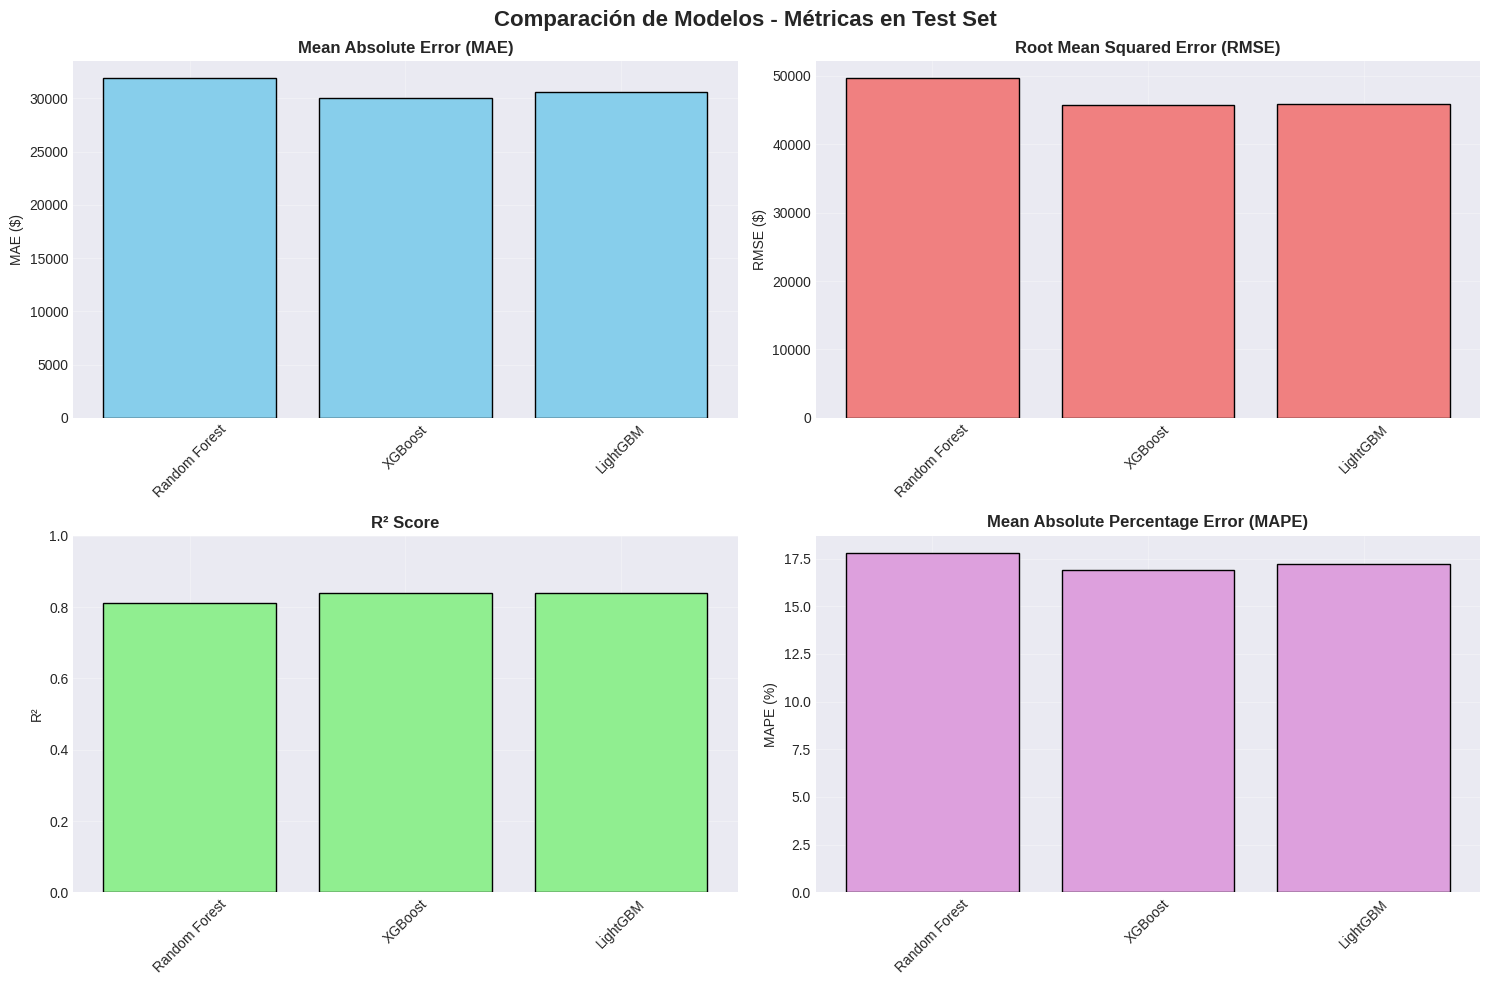

In [18]:
# Gráfico de comparación de métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparación de Modelos - Métricas en Test Set', fontsize=16, fontweight='bold')

# MAE
axes[0, 0].bar(test_results_df['Model'], test_results_df['MAE'], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# RMSE
axes[0, 1].bar(test_results_df['Model'], test_results_df['RMSE'], color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)', fontweight='bold')
axes[0, 1].set_ylabel('RMSE ($)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# R²
axes[1, 0].bar(test_results_df['Model'], test_results_df['R2'], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('R² Score', fontweight='bold')
axes[1, 0].set_ylabel('R²')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# MAPE
axes[1, 1].bar(test_results_df['Model'], test_results_df['MAPE (%)'], color='plum', edgecolor='black')
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Seleccionar el Mejor Modelo

In [19]:
# Seleccionar mejor modelo basado en RMSE en test set
best_model_idx = test_results_df['RMSE'].idxmin()
best_model_name = test_results_df.loc[best_model_idx, 'Model']
best_model = results['trained_models'][best_model_name]

print("=" * 80)
print("MEJOR MODELO SELECCIONADO")
print("=" * 80)
print(f"\nModelo: {best_model_name}")
print(f"\nMétricas en Test Set:")
print(f"  MAE:  ${test_results_df.loc[best_model_idx, 'MAE']:,.2f}")
print(f"  RMSE: ${test_results_df.loc[best_model_idx, 'RMSE']:,.2f}")
print(f"  R²:   {test_results_df.loc[best_model_idx, 'R2']:.4f}")
print(f"  MAPE: {test_results_df.loc[best_model_idx, 'MAPE (%)']:.2f}%")
print("\n" + "=" * 80)

MEJOR MODELO SELECCIONADO

Modelo: XGBoost

Métricas en Test Set:
  MAE:  $30,041.08
  RMSE: $45,710.14
  R²:   0.8406
  MAPE: 16.90%



## 9. Visualización de Predicciones del Mejor Modelo

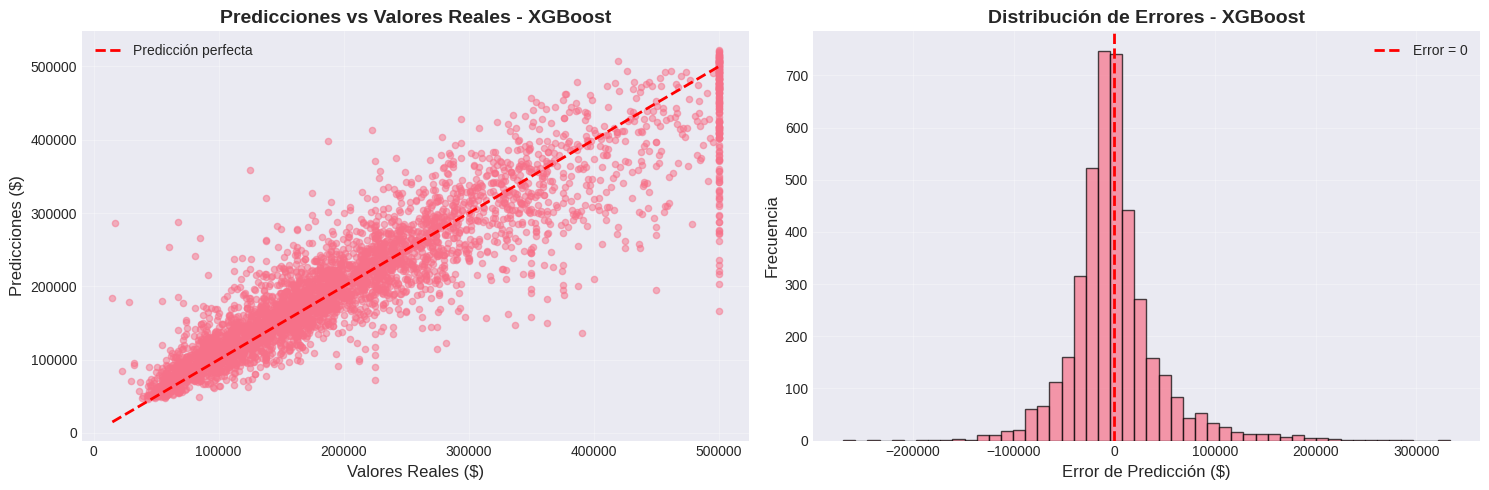


Estadísticas de Errores (XGBoost):
  Media de errores: $-143.19
  Desv. Std. de errores: $45,715.45
  Error mínimo: $-269,320.06
  Error máximo: $333,115.73


In [20]:
# Obtener predicciones del mejor modelo
y_test_pred_best = results['predictions'][best_model_name]['test']

# Gráfico de predicciones vs valores reales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Predicciones vs Valores Reales
axes[0].scatter(y_test, y_test_pred_best, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Valores Reales ($)', fontsize=12)
axes[0].set_ylabel('Predicciones ($)', fontsize=12)
axes[0].set_title(f'Predicciones vs Valores Reales - {best_model_name}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribución de errores
errors = y_test - y_test_pred_best
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Error = 0')
axes[1].set_xlabel('Error de Predicción ($)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title(f'Distribución de Errores - {best_model_name}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de errores
print(f"\nEstadísticas de Errores ({best_model_name}):")
print(f"  Media de errores: ${errors.mean():,.2f}")
print(f"  Desv. Std. de errores: ${errors.std():,.2f}")
print(f"  Error mínimo: ${errors.min():,.2f}")
print(f"  Error máximo: ${errors.max():,.2f}")

## 10. Importancia de Features 

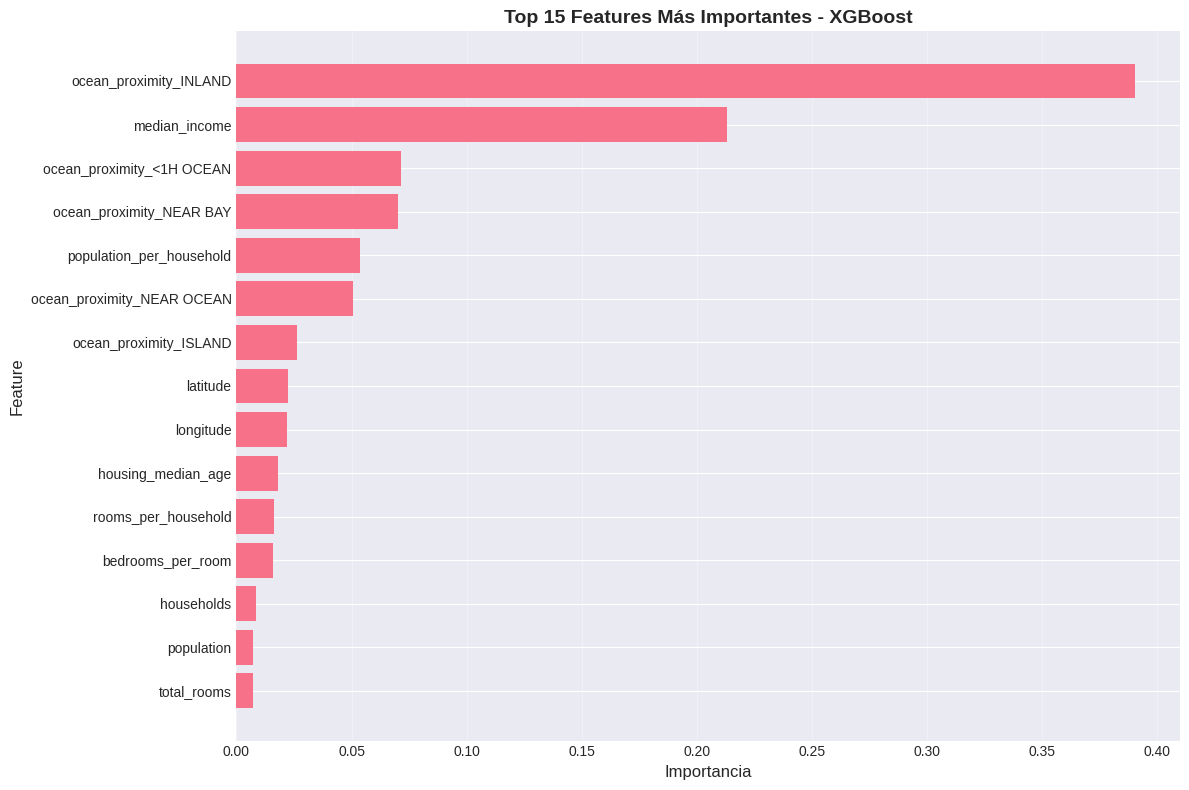


Top 10 Features Más Importantes:
                   Feature  Importance
    ocean_proximity_INLAND    0.390320
             median_income    0.213028
 ocean_proximity_<1H OCEAN    0.071645
  ocean_proximity_NEAR BAY    0.070137
  population_per_household    0.053550
ocean_proximity_NEAR OCEAN    0.050576
    ocean_proximity_ISLAND    0.026354
                  latitude    0.022458
                 longitude    0.021929
        housing_median_age    0.018273


In [21]:
# Verificar si el modelo tiene feature_importances_
if hasattr(best_model, 'feature_importances_'):
    # Obtener importancias
    importances = best_model.feature_importances_
    
    # Crear DataFrame con importancias
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Top 15 features más importantes
    top_features = feature_importance_df.head(15)
    
    # Visualización
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['Importance'], align='center')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importancia', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top 15 Features Más Importantes - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Features Más Importantes:")
    print(feature_importance_df.head(10).to_string(index=False))
else:
    print(f"\nEl modelo {best_model_name} no tiene atributo 'feature_importances_'")

## 11. Guardar el Mejor Modelo

In [22]:
# Guardar el mejor modelo
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}_{timestamp}.pkl"
model_path = os.path.join(MODEL_OUTPUT_DIR, model_filename)

joblib.dump(best_model, model_path)

print("=" * 80)
print("MODELO GUARDADO")
print("=" * 80)
print(f"Modelo: {best_model_name}")
print(f"Ruta: {model_path}")
print(f"Tamaño: {os.path.getsize(model_path) / 1024:.2f} KB")
print("=" * 80)

# Guardar también los resultados de entrenamiento
results_filename = f"training_results_{timestamp}.pkl"
results_path = os.path.join(MODEL_OUTPUT_DIR, results_filename)

# Preparar resultados para guardar
results_to_save = {
    'best_model_name': best_model_name,
    'train_metrics': train_results_df,
    'test_metrics': test_results_df,
    'feature_names': feature_names,
    'training_times': results['training_times']
}

joblib.dump(results_to_save, results_path)
print(f"\n✓ Resultados de entrenamiento guardados en: {results_path}")

MODELO GUARDADO
Modelo: XGBoost
Ruta: ../models/best_model_xgboost_20251110_025635.pkl
Tamaño: 747.05 KB

✓ Resultados de entrenamiento guardados en: ../models/training_results_20251110_025635.pkl


## 12. Resumen Final

In [23]:
print("=" * 80)
print("RESUMEN DEL ENTRENAMIENTO DE MODELOS")
print("=" * 80)

print(f"\n📊 Dataset:")
print(f"  • Total de muestras: {len(y_train) + len(y_test):,}")
print(f"  • Muestras de entrenamiento: {len(y_train):,}")
print(f"  • Muestras de prueba: {len(y_test):,}")
print(f"  • Features totales: {len(feature_names)}")

print(f"\n🤖 Modelos entrenados: {len(models)}")
for model_name in models.keys():
    print(f"  • {model_name}")

print(f"\n🏆 Mejor Modelo: {best_model_name}")
print(f"  • RMSE: ${test_results_df.loc[best_model_idx, 'RMSE']:,.2f}")
print(f"  • R²: {test_results_df.loc[best_model_idx, 'R2']:.4f}")
print(f"  • Tiempo de entrenamiento: {results['training_times'][best_model_name]:.2f}s")

print(f"\n💾 Archivos guardados:")
print(f"  • Modelo: {model_filename}")
print(f"  • Resultados: {results_filename}")

print(f"\n📈 Observaciones:")
print(f"  • Todos los modelos han sido entrenados exitosamente")
print(f"  • El modelo con mejor desempeño ha sido guardado")
print(f"  • Los resultados están listos para evaluación detallada")

print(f"\n✅ Entrenamiento completado exitosamente")
print("=" * 80)

RESUMEN DEL ENTRENAMIENTO DE MODELOS

📊 Dataset:
  • Total de muestras: 20,640
  • Muestras de entrenamiento: 16,512
  • Muestras de prueba: 4,128
  • Features totales: 16

🤖 Modelos entrenados: 3
  • Random Forest
  • XGBoost
  • LightGBM

🏆 Mejor Modelo: XGBoost
  • RMSE: $45,710.14
  • R²: 0.8406
  • Tiempo de entrenamiento: 0.41s

💾 Archivos guardados:
  • Modelo: best_model_xgboost_20251110_025635.pkl
  • Resultados: training_results_20251110_025635.pkl

📈 Observaciones:
  • Todos los modelos han sido entrenados exitosamente
  • El modelo con mejor desempeño ha sido guardado
  • Los resultados están listos para evaluación detallada

✅ Entrenamiento completado exitosamente
